In [5]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Pull Data 
ada_data = yf.download('ADA-USD', start='2017-01-01', end='2022-01-01')
ada_df = pd.DataFrame(ada_data)

[*********************100%***********************]  1 of 1 completed


In [19]:
ada_df = ada_df.drop(columns=['Adj Close', 'Volume', 'Open', 'High', 'Low'])

In [23]:
ada_df.head()

,Close
Date,
2017-11-09,0.032053
2017-11-10,0.027119
2017-11-11,0.027437
2017-11-12,0.023977
2017-11-13,0.025808


In [24]:
short_window = 8
long_window = 21

In [26]:
# Generate the short and long moving averages (50 and 100 days, respectively)
ada_df['SMA8'] = ada_df['Close'].rolling(window=short_window).mean()
ada_df['SMA21'] = ada_df['Close'].rolling(window=long_window).mean()

# Prepopulate the `Signal` for trading
ada_df['Signal'] = 0.0

In [27]:
ada_df.dropna()

,Close,SMA8,SMA21,Signal
Date,,,,
2017-11-29,0.089718,0.051401,0.036476,0.0
2017-11-30,0.119883,0.062818,0.040658,0.0
2017-12-01,0.131352,0.075806,0.045622,0.0
2017-12-02,0.132351,0.088803,0.050618,0.0
2017-12-03,0.131807,0.101473,0.055752,0.0
...,...,...,...,...
2021-12-28,1.402264,1.412584,1.326062,0.0
2021-12-29,1.330814,1.418829,1.322907,0.0
2021-12-30,1.360415,1.422876,1.326239,0.0


In [28]:
# Generate the trading signal 0 or 1,
# where 1 is when short-window (SMA50) is greater than the long (SMA 100)
# and 0 otherwise
ada_df['Signal'][short_window:] = np.where(
    ada_df['SMA8'][short_window:] > ada_df['SMA21'][short_window:], 1.0, 0.0
)

In [29]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
ada_df['Entry/Exit'] = ada_df['Signal'].diff()

# Review the DataFrame
ada_df.tail(10)

,Close,SMA8,SMA21,Signal,Entry/Exit
Date,,,,,
2021-12-23,1.474691,1.283681,1.323472,0.0,0.0
2021-12-24,1.392367,1.302661,1.315654,0.0,0.0
2021-12-25,1.453495,1.331861,1.317215,1.0,1.0
2021-12-26,1.456045,1.358550,1.320926,1.0,0.0
2021-12-27,1.512913,1.392081,1.325094,1.0,0.0
2021-12-28,1.402264,1.412584,1.326062,1.0,0.0
2021-12-29,1.330814,1.418829,1.322907,1.0,0.0
2021-12-30,1.360415,1.422876,1.326239,1.0,0.0
2021-12-31,1.310209,1.402315,1.330930,1.0,0.0


In [44]:
# Filling missing values with the previous ones
ada_df = ada_df.fillna(method ='pad')

In [50]:
ada_rnn = ada_df[['Close']]
ada_rnn

,Close
Date,
2017-11-09,0.032053
2017-11-10,0.027119
2017-11-11,0.027437
2017-11-12,0.023977
2017-11-13,0.025808
...,...
2021-12-28,1.402264
2021-12-29,1.330814
2021-12-30,1.360415


In [45]:
 def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [51]:
ada_rnn.isnull().sum()

Close    0
dtype: int64

In [53]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(ada_rnn, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[0.032053   0.027119   0.027437   0.023977   0.025808   0.02623
  0.026445   0.02758    0.025773   0.026369   0.028084   0.029581
  0.02833    0.028549   0.027444   0.028382   0.030447   0.036332
  0.050593   0.119744   0.089718   0.119883   0.13135201 0.132351
  0.131807   0.13586999 0.127488   0.117839   0.105501   0.115465  ]
 [0.027119   0.027437   0.023977   0.025808   0.02623    0.026445
  0.02758    0.025773   0.026369   0.028084   0.029581   0.02833
  0.028549   0.027444   0.028382   0.030447   0.036332   0.050593
  0.119744   0.089718   0.119883   0.13135201 0.132351   0.131807
  0.13586999 0.127488   0.117839   0.105501   0.115465   0.119609  ]
 [0.027437   0.023977   0.025808   0.02623    0.026445   0.02758
  0.025773   0.026369   0.028084   0.029581   0.02833    0.028549
  0.027444   0.028382   0.030447   0.036332   0.050593   0.119744
  0.089718   0.119883   0.13135201 0.132351   0.131807   0.13586999
  0.127488   0.117839   0.105501   0.115465   0.119609

In [54]:
 # Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [55]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [56]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[7.42277139e-03]
  [2.89682454e-03]
  [3.18852520e-03]
  [1.46768698e-05]
  [1.69424728e-03]
  [2.08134758e-03]
  [2.27856610e-03]
  [3.31969951e-03]
  [1.66214269e-03]
  [2.20885182e-03]
  [3.78201749e-03]
  [5.15521038e-03]
  [4.00767223e-03]
  [4.20856081e-03]
  [3.19494611e-03]
  [4.05537120e-03]
  [5.94959126e-03]
  [1.13478858e-02]
  [2.44294636e-02]
  [8.78614974e-02]
  [6.03187228e-02]
  [8.79889999e-02]
  [9.85094895e-02]
  [9.94258593e-02]
  [9.89268526e-02]
  [1.02653828e-01]
  [9.49650477e-02]
  [8.61140443e-02]
  [7.47964315e-02]
  [8.39363795e-02]]

 [[2.89682454e-03]
  [3.18852520e-03]
  [1.46768698e-05]
  [1.69424728e-03]
  [2.08134758e-03]
  [2.27856610e-03]
  [3.31969951e-03]
  [1.66214269e-03]
  [2.20885182e-03]
  [3.78201749e-03]
  [5.15521038e-03]
  [4.00767223e-03]
  [4.20856081e-03]
  [3.19494611e-03]
  [4.05537120e-03]
  [5.94959126e-03]
  [1.13478858e-02]
  [2.44294636e-02]
  [8.78614974e-02]
  [6.03187228e-02]
  [8.79889999e-02]
  [9.8

In [57]:
 # Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [58]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

2022-01-25 22:03:19.539998: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [59]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [60]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 30, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [61]:
 # Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
12/12 [==============================] - 4s 30ms/step - loss: 0.0271
Epoch 2/10
12/12 [==============================] - 0s 27ms/step - loss: 0.0136
Epoch 3/10
12/12 [==============================] - 0s 29ms/step - loss: 0.0079
Epoch 4/10
12/12 [==============================] - 0s 31ms/step - loss: 0.0057
Epoch 5/10
12/12 [==============================] - 0s 27ms/step - loss: 0.0064
Epoch 6/10
12/12 [==============================] - 0s 27ms/step - loss: 0.0070
Epoch 7/10
12/12 [==============================] - 0s 26ms/step - loss: 0.0050
Epoch 8/10
12/12 [==============================] - 0s 26ms/step - loss: 0.0051
Epoch 9/10
12/12 [==============================] - 0s 27ms/step - loss: 0.0051
Epoch 10/10
12/12 [==============================] - 0s 27ms/step - loss: 0.0043


In [65]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.41908636689186096

In [66]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [67]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [69]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = ada_rnn.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
Date,,
2020-10-13,0.108852,0.087093
2020-10-14,0.107297,0.087689
2020-10-15,0.106635,0.088362
2020-10-16,0.104064,0.089090
2020-10-17,0.106104,0.089830


<AxesSubplot:title={'center':'Actual Vs. Predicted Gold Prices'}, xlabel='Date'>

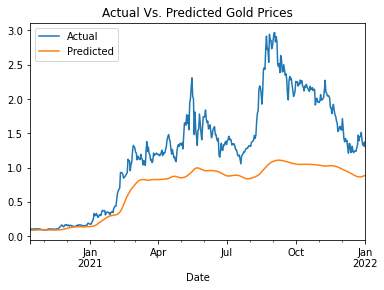

In [70]:
 # Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted ADA prices")